In [1]:
!pip install torch
!pip install torchvision
!pip install gym

    100% |████████████████████████████████| 519.5MB 28kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58b86000 @  0x7fc94772e2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 2.0MB 13.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 1.5MB 14.4MB/s 
    100% |████████████████████████████████| 1.0MB 18.2MB/s 
  Running setup.py bdist_wheel for gym ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/6c/3a/0e/b86dee98876bb56cdb482cc1f72201035e46d1baf69d10d028
Successfully built gym


In [0]:
import gym
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, utils, datasets
import torchvision.models as models
import os
from IPython import display
from itertools import chain
from tqdm import tqdm
from functools import reduce



In [0]:


 
class PolicyNetwork(nn.Module):
    def __init__(self, inOpts, outOpts):
      super(PolicyNetwork, self).__init__()
      self.net=nn.Sequential(nn.Linear(inOpts, 10),
                            nn.ReLU(), 
                            nn.Linear(10,10),
                            nn.ReLU(),
                            nn.Linear(10,10),
                            nn.ReLU(),
                            nn.Linear(10, outOpts))
      self.softmax = nn.Softmax(dim=1)
    
    def forward(self, env, justProbs=False):
      scores= self.net(env)
      probs=self.softmax(scores)
      if justProbs:
        return probs
      batch_size=env.shape[0]
      actions = np.empty((batch_size,1), dtype=np.uint8)
      probs_np = probs.cpu().detach().numpy()
      for i in range(batch_size):
        action_one_hot = np.random.multinomial(1, probs_np[i])
        action_idx = np.argmax(action_one_hot)
        actions[i,0] = action_idx
      return(probs, actions)
 

class ValueNetwork(nn.Module):
    def __init__(self, num):
      super(ValueNetwork, self).__init__()
      self.net=nn.Sequential(
      nn.Linear(4,10),
      nn.ReLU(),
      nn.Linear(10,10), 
      nn.ReLU(),
      nn.Linear(10, 10),
      nn.ReLU(),
      nn.Linear(10,1))
      
    def forward(self, x):
      return(self.net(x))
      
      
      
class AdvantageDataset(Dataset):                                                                                                                    
    def __init__(self, experience):                                                                                                                 
        super(AdvantageDataset, self).__init__()                                                                                                    
        self._exp = experience                                                                                                                      
        self._num_runs = len(experience)                                                                                                            
        self._length = reduce(lambda acc, x: acc + len(x), experience, 0)                                                                           
 
    def __getitem__(self, index):                                                                                                                   
        idx = 0                                                                                                                                     
        seen_data = 0                                                                                                                               
        current_exp = self._exp[0]                                                                                                                  
        while seen_data + len(current_exp) - 1 < index:                                                                                             
            seen_data += len(current_exp)                                                                                                           
            idx += 1                                                                                                                                
            current_exp = self._exp[idx]                                                                                                            
        chosen_exp = current_exp[index - seen_data]                                                                                                 
        return chosen_exp[0], chosen_exp[4]                                                                                                         
 
    def __len__(self):                                                                                                                              
        return self._length                                                                                                                         
 
 
class PolicyDataset(Dataset):                                                                                                                       
    def __init__(self, experience):                                                                                                                 
        super(PolicyDataset, self).__init__()                                                                                                       
        self._exp = experience                                                                                                                      
        self._num_runs = len(experience)                                                                                                            
        self._length = reduce(lambda acc, x: acc + len(x), experience, 0)                                                                           
 
    def __getitem__(self, index):                                                                                                                   
        idx = 0                                                                                                                                     
        seen_data = 0                                                                                                                               
        current_exp = self._exp[0]                                                                                                                  
        while seen_data + len(current_exp) - 1 < index:                                                                                             
            seen_data += len(current_exp)                                                                                                           
            idx += 1                                                                                                                                
            current_exp = self._exp[idx]                                                                                                            
        chosen_exp = current_exp[index - seen_data]                                                                                                 
        return chosen_exp                                                                                                                           
 
    def __len__(self):                                                                                                                              
        return self._length                                                                                                                         
 
 
def calc_returns(rollout, gamma):
  current_return = 0
  for i in reversed(range(len(rollout))):
    state, action_dist, action, reward = rollout[i]
    ret= reward+gamma*current_return
    rollout[i] = (state, action_dist, action, reward, ret)
    current_return = ret
    
def multinomial_likelihood(dist, idx):
    return dist[range(dist.shape[0]), idx.long()[:, 0]].unsqueeze(1)


In [7]:
def main():
 
    env = gym.make('CartPole-v0')
    
    policy = PolicyNetwork(4, 2)
    value = ValueNetwork(4)
    #Not sure why cuda isn't working, will come back to if necessary
    #policy=policy.cuda()
    #value=value.cuda()
    params = chain(policy.parameters(), value.parameters())
    optimizer = optim.Adam(params, lr= .001, betas = (.9, .999), weight_decay=.01)
    value_criteria = nn.MSELoss()
    
    epsilon = .2
    ppo_lb = 1-epsilon
    ppo_ub = 1+epsilon
    
    epochs=25
    policy_epochs = 5
    num_rollouts = 100
    max_ep_length= 200
    gamma=.99
    batch_size=256
    val_losses=[]
    policy_losses=[]
    avg_reward=[]
    
    loop = tqdm(total=epochs, position = 0, leave=False)
    
    for e in range(epochs):
      #print(e)
      experiences=[]
      rewards = []
      for _ in range(num_rollouts):
        current_rollout=[]
        s = env.reset()
        episode_reward=0
        for b in range(max_ep_length):
          state = torch.from_numpy(s).float().unsqueeze(0)
          action_dist, action = policy(state)
          action_dist, action = action_dist[0], action[0]
          #print(action)
          s_prime, r, t, _ = env.step(action.item())
          current_rollout.append((s, action_dist.cpu().detach().numpy(), action, r))
          episode_reward+=r
          if t: 
            break
          s=s_prime
        calc_returns(current_rollout, gamma)
        experiences.append(current_rollout)
        rewards.append(episode_reward)
      
      #return(rewards)
      #print(len(experiences))
      #print(experiences)
      avg_r = np.mean([x[0][4] for x in experiences])
      #loop.set_description('average reward: % 6.2f' % (avg_r))
      experience_dataset = PolicyDataset(experiences)
      data_loader = DataLoader(experience_dataset, batch_size=batch_size,
                                 shuffle=True,
                                 pin_memory=True)
      avg_policy_loss=0
      avg_val_loss=0
      for i in range(policy_epochs):
        avg_policy_loss = 0
        avg_val_loss = 0
        for state, old_action_dist, old_action, reward, ret in data_loader:
          #print(state.size(), old_action_dist.size(), old_action.size(), reward.size(), ret.size())
          optimizer.zero_grad()
          act_dist=policy(state.float(),True)
          current_likelihood = multinomial_likelihood(act_dist, old_action)
          old_likelihood = multinomial_likelihood(old_action_dist, old_action)
          ratio = (current_likelihood / old_likelihood).squeeze(1)
          
          expected_returns = value(state.float())
          val_loss = value_criteria(expected_returns.squeeze(1), ret.float())
          #print(ret.size())
          #print(expected_returns.squeeze(1).size())
          advantage = ret.float() - expected_returns.squeeze(1)
          #print(advantage.size())
          #print(ratio.size())
          #printaasfd
          lhs = ratio * advantage
          #print(lhs.size())
          rhs = torch.clamp(ratio, ppo_lb, ppo_ub) * advantage
          #print(rhs.size())
          policy_loss = -torch.mean(torch.min(lhs, rhs))

          # For logging
          avg_val_loss += val_loss.item()
          avg_policy_loss += policy_loss.item()
          val_losses.append(val_loss.item())
          policy_losses.append(policy_loss.item())

          # Backpropagate
          loss = policy_loss + val_loss
          loss.backward()
          optimizer.step()
      avg_val_loss /= len(data_loader)
      avg_policy_loss /= len(data_loader)
      avg_reward.append(avg_r)
      loop.set_description('avg reward: % 6.2f, value loss: % 6.2f, policy loss: % 6.2f' % (avg_r, avg_val_loss, avg_policy_loss))
      loop.update(1)
    return policy, value, val_losses, policy_losses, avg_reward
            
rewards=main()

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
avg reward:  86.17, value loss:  293.32, policy loss:  -0.44: 100%|██████████| 25/25 [02:16<00:00,  7.48s/it]

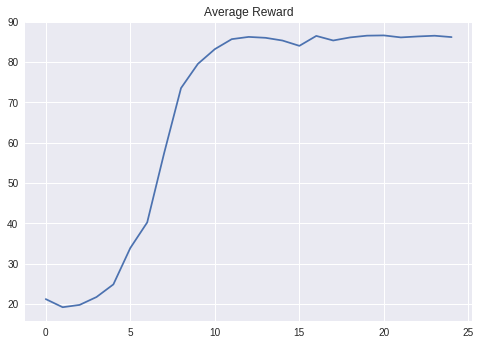

In [13]:
#print(rewards)
#plt.plot(rewards[2])
#plt.show()
#plt.plot(rewards[3])
#plt.show()
plt.plot(rewards[4])
plt.title("Average Reward")
plt.show()


In [0]:
    policy_optim = optim.Adam(policy.parameters(), lr=1e-2, weight_decay=0.01)
    value_optim = optim.Adam(value.parameters(), lr=1e-3, weight_decay=1)
    observation = env.reset()
    print(observation)
    for _ in range(1000):
        #env.render()
        action = env.action_space.sample() # your agent here (this takes random actions)
        print(action)
        observation, reward, done, info = env.step(action)
        print(observation)
        print(reward)
        print(done)
        print(info)

    # ... more stuff here...
 
    # Hyperparameters
    epochs = 1000
    env_samples = 100
    episode_length = 200
    gamma = 0.9
    value_epochs = 2
    policy_epochs = 5
    batch_size = 32
    policy_batch_size = 256
    epsilon = 0.2
 
    for _ in range(epochs):
        # generate rollouts
        rollouts = []
        for _ in range(env_samples):
            # don't forget to reset the environment at the beginning of each episode!
            # rollout for a certain number of steps!
            print("hi")
 
        print('avg standing time:', standing_len / env_samples)
        calculate_returns(rollouts, gamma)
 
        # Approximate the value function
        value_dataset = AdvantageDataset(rollouts)
        value_loader = DataLoader(value_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
        for _ in range(value_epochs):
            # train value network
            print("train value")
 
        calculate_advantages(rollouts, value)
 
        # Learn a policy
        policy_dataset = PolicyDataset(rollouts)
        policy_loader = DataLoader(policy_dataset, batch_size=policy_batch_size, shuffle=True, pin_memory=True)
        for _ in range(policy_epochs):
            # train policy network
            print("train policy")